<a href="https://colab.research.google.com/github/YagmurTaze/OCR-ICR/blob/main/2_Handwriting_Words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

from google.colab import files

## Functions

In [39]:
def apply_contrast(image, contrast):
    # Görüntüyü gri tonlamaya dönüştür
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Yeni bir görüntü oluşturmak için gri tonlamalı görüntüyü kopyala, orijinal resmi korur
    contrast_image = np.copy(image)

    # Kontrastı uygula
    for i in range(contrast_image.shape[0]):
        for j in range(contrast_image.shape[1]):
            for k in range(3):
                new_value = contrast * (contrast_image[i, j, k] - 128) + 128
                if new_value < 0:
                    new_value = 0
                elif new_value > 255:
                    new_value = 255
                contrast_image[i, j, k] = new_value

    return contrast_image

In [40]:
def thresholding(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,80,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    return thresh

In [41]:
def resize_image(img):
    # Görüntünün boyutlarını alın
    height, width, _ = img.shape

    #Yeniden boyutlandırma oranını hesaplayın
    rescale_factor = min(64 / height, 64 / width)

    # Yeniden boyutlandırılmış görüntü boyutlarını hesaplayın
    new_height = int(height * rescale_factor)
    new_width = int(width * rescale_factor)

    # Yeniden boyutlandırma işlemi
    resized_image = cv2.resize(img, (new_width, new_height))

    # Yeniden boyutlandırılmış görüntüyü 64x64 boyutlarına ekleyin
    border_top = (64 - new_height) // 2
    border_bottom = 64 - new_height - border_top
    border_left = (64 - new_width) // 2
    border_right = 64 - new_width - border_left
    padded_image = cv2.copyMakeBorder(resized_image, border_top, border_bottom, border_left, border_right, cv2.BORDER_CONSTANT, value=[255, 255, 255])  # Beyaz arka plan ekleme
    padded_image = np.expand_dims(padded_image, axis = 0)

    return padded_image

In [42]:
def line_segmentation(img):

  img_new = img.copy()

  kernel = np.ones((5,85), np.uint8)
  dilated = cv2.dilate(thresh_img, kernel, iterations = 1)

  (contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)

  cropped_lines = []

  for ctr in sorted_contours_lines:

    x,y,w,h = cv2.boundingRect(ctr)

    cropped_line = img[y:y+h, x:x+w].copy()
    cropped_lines.append(cropped_line)

    img_new = cv2.rectangle(img_new, (x,y), (x+w, y+h), (40, 100, 250), 2)

  plt.imshow(dilated, cmap='gray')
  plt.title('Dilated Image')
  plt.show()

  return cropped_lines,img_new

In [43]:
def word_segmentation(img):

  img_new = img.copy()

  thresh_img = thresholding(img)

  kernel = np.ones((15,15), np.uint8)
  dilated = cv2.dilate(thresh_img, kernel, iterations = 1)

  (contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  sorted_contours_words = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[0]) # (x, y, w, h)

  cropped_words = []

  for ctr in sorted_contours_words:

    x,y,w,h = cv2.boundingRect(ctr)

    cropped_line = img[y:y+h, x:x+w].copy()

    if h > 64:
          new_h = min(h, 64)
          cropped_line = cv2.resize(cropped_line, (w, new_h))

    cropped_words.append(cropped_line)

    img_new = cv2.rectangle(img_new, (x,y), (x+w, y+h), (40, 100, 250), 2)


  return cropped_words, img_new

## Preprocess The Image

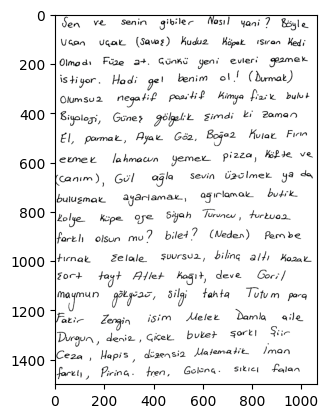

In [44]:
img = cv2.imread("/content/second.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = apply_contrast(img, 7)
thresh_img = thresholding(img);

plt.imshow(img);

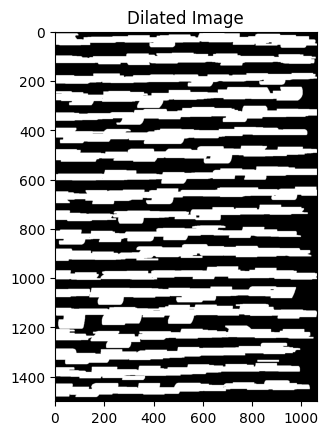

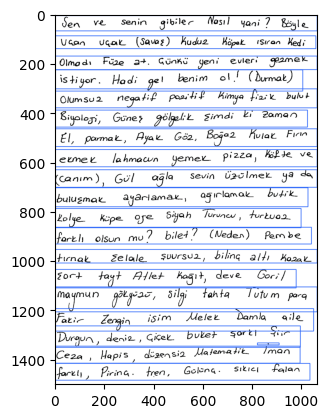

In [45]:
lines, new = line_segmentation(img)
plt.imshow(new)

In [46]:
import cv2
import numpy as np
from keras.models import load_model, Model
from keras import backend as K
from keras.layers import Input

# Load the trained model
model = load_model("/content/wordModel (2).h5", compile=False)

# Define the alphabet and other parameters
alphabets = u"ABCÇDEFGĞHIİJKLMNOÖPRSŞTUÜVYZabcçdefgğhıijklmnoöprsştuüvyz?'()\".,0123456789 "
max_str_len = 24
num_of_timestamps = 64

def preprocess(img):
    if len(img.shape) == 3:  # If the image has 3 channels, convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (h, w) = img.shape
    final_img = np.ones([64, 256]) * 255  # blank white image

    # crop
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]

    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret += alphabets[ch]
    return ret

# Create a new model that outputs predictions directly
input_data = Input(shape=(256, 64, 1), name='input')
y_pred = model.get_layer('softmax').output
prediction_model = Model(inputs=model.input[0], outputs=y_pred)

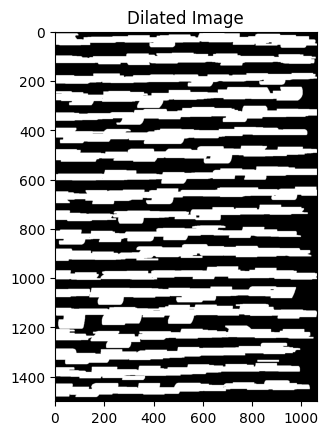

  0%|          | 0/20 [00:00<?, ?it/s]

1/1 [==============================] - 0s 90ms/step


  5%|▌         | 1/20 [00:05<01:49,  5.74s/it]

1/1 [==============================] - 0s 107ms/step


 10%|█         | 2/20 [00:07<00:56,  3.14s/it]

1/1 [==============================] - 0s 93ms/step


 15%|█▌        | 3/20 [00:08<00:39,  2.34s/it]

1/1 [==============================] - 0s 100ms/step


 20%|██        | 4/20 [00:10<00:34,  2.16s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██▌       | 5/20 [00:11<00:27,  1.86s/it]

1/1 [==============================] - 0s 167ms/step


 30%|███       | 6/20 [00:13<00:26,  1.87s/it]

1/1 [==============================] - 0s 106ms/step


 35%|███▌      | 7/20 [00:15<00:24,  1.88s/it]

1/1 [==============================] - 0s 83ms/step


 40%|████      | 8/20 [00:16<00:19,  1.60s/it]

1/1 [==============================] - 0s 90ms/step


 45%|████▌     | 9/20 [00:18<00:17,  1.60s/it]

1/1 [==============================] - 0s 86ms/step


 50%|█████     | 10/20 [00:18<00:13,  1.36s/it]

1/1 [==============================] - 0s 87ms/step


 55%|█████▌    | 11/20 [00:20<00:11,  1.33s/it]

1/1 [==============================] - 0s 92ms/step


 60%|██████    | 12/20 [00:21<00:11,  1.41s/it]

1/1 [==============================] - 0s 93ms/step


 65%|██████▌   | 13/20 [00:22<00:09,  1.31s/it]

1/1 [==============================] - 0s 90ms/step


 70%|███████   | 14/20 [00:24<00:08,  1.34s/it]

1/1 [==============================] - 0s 147ms/step


 75%|███████▌  | 15/20 [00:26<00:07,  1.47s/it]

1/1 [==============================] - 0s 151ms/step


 80%|████████  | 16/20 [00:28<00:07,  1.85s/it]

1/1 [==============================] - 0s 85ms/step


 85%|████████▌ | 17/20 [00:30<00:05,  1.86s/it]

1/1 [==============================] - 0s 93ms/step


 90%|█████████ | 18/20 [00:30<00:02,  1.35s/it]

1/1 [==============================] - 0s 89ms/step


 95%|█████████▌| 19/20 [00:32<00:01,  1.45s/it]

1/1 [==============================] - 0s 99ms/step


100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


Sen ve senin gibiler Nasıl vani ? Böyle 
Uçan uçak (savaş) Kuduz Köpek ısıran NKeti 
Olmadı Füze at. Çünkü yeni evleri gezmek 
istiyor. Hadi gel benim  ol I (Durmak) n 
Olumsuz negatip paczitif Kimya fizik bulut 
Biyoloji, Güneş gölgelik şimdi ki Zaman 
El, parmak, Ayak Göz, Bogaz Kulak Fırın 
ekmek lahmacun yemek pizza, Köfte ve 
(canım) 1 Gül ağla sevin üzülmek ya da 
buluşmak ayarlamak ağırlamak butik 
Kolye Küpe oje Siyah Turuncu " turkuoz 
farklı olsun mu ? bilet ? (Neden) Pembe 
tırnak Şelale şuursuz, bilinç altı Kazak 
şort tayt Atlet Kağıt, deve  Goril 
maymun  pakyza, silgi tahta  Tutum para 
Fakir ü Zengin isim Melek  Damla " C. aile 
Durgun, deniz u " Çiçek buket şarkı i Şiir 
 
Ceza  " Hapis ı düzensiz Matematik ıman 
farklı " Pirinç. tren, Gülünç. sıkıcı falan 



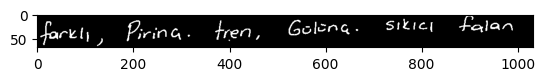

In [47]:
from tqdm import tqdm

text = ""
lines, _ = line_segmentation(img)

def predict_text_from_image_array(image_array):
        image = preprocess(image_array)
        image = image / 255.0

        # Predict
        pred = prediction_model.predict(image.reshape(1, 256, 64, 1))
        decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1],
                                          greedy=True)[0][0])

        return num_to_label(decoded[0])


for line in tqdm(lines):


  plt.imshow(line);
  words, _ = word_segmentation(line)

  predicted_words =[]

  for img_array in words:
    # Load and preprocess the new image from numpy array

    predicted_text = predict_text_from_image_array(img_array)
    #print('Predicted text:', predicted_text)

    predicted_words.append(predicted_text)
    text += predicted_text
    text += " "
  text += "\n"

print()
print(text)

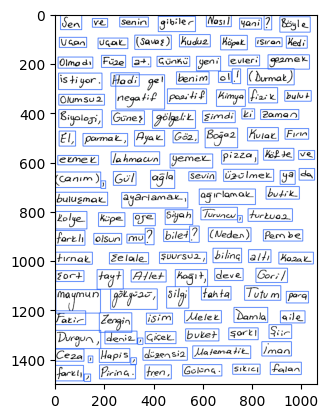

In [48]:
words, new = word_segmentation(img)
plt.imshow(new)